In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [21]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

In [22]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [23]:
# import de code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

In [24]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

In [36]:
# gather specs for a system
# system = light + replacedecision + test
components = [componentspecs.light, componentspecs.switch]
connections = [connectionspecs.wire, connectionspecs.wire2]
tests = [testspecs.testObserveHealth]
assembly = {
    "components"  : components,
    "connections" : connections,
    "structure"   : assemblyspecs.structure1,   #light, switch, wire
    "tests"       : tests,
    "testmapping" : testspecs.testmapping4
}

In [115]:
oopn = oopnbuilder.OopnBuilder(assembly).getOopn()


star building system: structure1
number of components: 2
{0: {'PresentPowerInputsLight': 'yes', 'PresentPowerOutputsSwitch': 'yes', 'healthWire': 'ok'}, 1: {'PresentPowerInputsLight': 'no', 'PresentPowerOutputsSwitch': 'yes', 'healthWire': 'broken'}, 2: {'PresentPowerInputsLight': 'no', 'PresentPowerOutputsSwitch': 'no', 'healthWire': 'ok'}, 3: {'PresentPowerInputsLight': 'yes', 'PresentPowerOutputsSwitch': 'no', 'healthWire': 'broken'}}
number of connections: 1
number of tests: 0


In [116]:
# create diagram object
diagram = gum.InfluenceDiagram()

In [117]:
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for connection: Wire


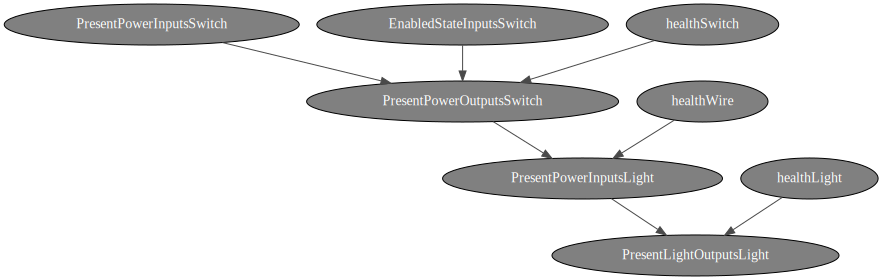

In [119]:
gnb.showInfluenceDiagram(diagram, size=60)

In [118]:
diagram.cpt(diagram.idFromName("healthWire"))

(pyAgrum.Potential<double>@0x2c0f1cf0) 
  healthWire       |
ok       |broken   |
---------|---------|
 0.9900  | 0.0100  |